In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model

In [2]:
train_labels_path = "retinal-disease-classification/Training_Set/RFMiD_Training_Labels.csv"
val_labels_path = "retinal-disease-classification/Evaluation_Set/RFMiD_Validation_Labels.csv"
test_labels_path = "retinal-disease-classification/Test_Set/RFMiD_Testing_Labels.csv"

# Load CSVs
train_labels = pd.read_csv(train_labels_path)
val_labels = pd.read_csv(val_labels_path)
test_labels = pd.read_csv(test_labels_path)

train_labels.head()


,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Define selected diseases
selected_diseases = ['DR', 'MH', 'ODC', 'TSLN', 'DN', 'MYA', 'ARMD', 'BRVO', 'ODP', 'ODE', 'LS', 'RS', 'CSR', 'CRS']

train_labels_filtered = train_labels[['ID', 'Disease_Risk'] + selected_diseases]
val_labels_filtered = val_labels[['ID', 'Disease_Risk'] + selected_diseases]
test_labels_filtered = test_labels[['ID', 'Disease_Risk'] + selected_diseases]

# Update Disease_Risk to 1 only if at least one selected disease is present
def update_disease_risk(df, disease_columns):
    df.loc[:,'Disease_Risk'] = (df[disease_columns].sum(axis=1) > 0).astype(int)
    return df

train_labels_filtered = update_disease_risk(train_labels_filtered, selected_diseases)
val_labels_filtered = update_disease_risk(val_labels_filtered, selected_diseases)
test_labels_filtered = update_disease_risk(test_labels_filtered, selected_diseases)

print(train_labels_filtered.head())
print(train_labels_filtered["Disease_Risk"].value_counts())

   ID  Disease_Risk  DR  MH  ODC  TSLN  DN  MYA  ARMD  BRVO  ODP  ODE  LS  RS  \
0   1             1   1   0    0     0   0    0     0     0    0    0   0   0   
1   2             1   1   0    0     0   0    0     0     0    0    0   0   0   
2   3             1   1   0    0     0   0    0     0     0    0    0   0   0   
3   4             1   0   1    1     0   0    0     0     0    0    0   0   0   
4   5             1   1   0    0     0   0    0     0     0    0    0   1   0   

   CSR  CRS  
0    0    0  
1    0    0  
2    0    0  
3    0    0  
4    0    0  
Disease_Risk
1    1403
0     517
Name: count, dtype: int64


In [4]:
class DataGenerator(Sequence):
    def __init__(self, img_dir, labels_df, batch_size=32, img_size=(224, 224), shuffle=True, augment=False, augment_minority_class=False):
        self.img_dir = img_dir
        self.labels_df = labels_df
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.augment_minority_class = augment_minority_class
        self.indices = np.arange(len(self.labels_df))
        self.datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.15,
            zoom_range=0.15,
            horizontal_flip=True
        )
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.labels_df) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = [self.labels_df.iloc[i] for i in batch_indices]
        X, y = self.__data_generation(batch_data)   
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_data):
        X = np.empty((self.batch_size, *self.img_size, 3))
        y = np.empty((self.batch_size, len(self.labels_df.columns) - 1), dtype=int)
        
        for i, data in enumerate(batch_data):
            img_name = str(data['ID']) + '.png'  # Access the filename from the 'ID' column
            img_path = os.path.join(self.img_dir, img_name)
            img = load_img(img_path, target_size=self.img_size)  # Load the image and resize it
            img = img_to_array(img) / 255.0  # Normalize the image pixels
            
            if self.augment:
                # Check for the minority class if true apply augmentation
                 if (self.augment_minority_class and data['Disease_Risk'] == 0) or not self.augment_minority_class:
                    img = self.datagen.random_transform(img)
            
            X[i,] = img  # Add the image to the batch
            y[i,] = data.iloc[1:].values  # Extract labels from the DataFrame
        
        return X, y

In [5]:
# Calculate class weights for `Disease_Risk` (0 = No Disease, 1 = Disease)
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=train_labels_filtered['Disease_Risk'].values)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights for Disease_Risk:", class_weight_dict)


Class weights for Disease_Risk: {0: 1.8568665377176015, 1: 0.684248039914469}


In [6]:
train_img_dir = "retinal-disease-classification\\Training_Set\\Training"
val_img_dir = "retinal-disease-classification\\Evaluation_Set\\Validation"
test_img_dir = "retinal-disease-classification\\Test_Set\\Test"

# Initialize data generators
train_generator = DataGenerator(
    img_dir=train_img_dir, 
    labels_df=train_labels_filtered, 
    batch_size=32, 
    shuffle=True,
    augment_minority_class=True)

val_generator = DataGenerator(
    img_dir=val_img_dir, 
    labels_df=val_labels_filtered, 
    batch_size=32, 
    shuffle=False,
    augment_minority_class=False)

test_generator = DataGenerator(
    img_dir=test_img_dir, 
    labels_df=test_labels_filtered, 
    batch_size=32, 
    shuffle=False,
    augment_minority_class=True)


In [7]:
# Load the EfficientNetB0 model
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Freeze all layers except the last 20
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(train_labels_filtered.shape[1] - 1, activation="sigmoid")  # One output per disease, using sigmoid for multi-label
])

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", AUC(name="auc")])


In [ ]:
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, checkpoint]
)

c:\Users\EliteBook\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 488s 8s/step - accuracy: 0.9161 - auc: 0.7576 - loss: 0.3376 - val_accuracy: 1.0000 - val_auc: 0.8233 - val_loss: 0.2654
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 431s 7s/step - accuracy: 0.9993 - auc: 0.8068 - loss: 0.2632 - val_accuracy: 1.0000 - val_auc: 0.8179 - val_loss: 0.2624
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 427s 7s/step - accuracy: 1.0000 - auc: 0.8099 - loss: 0.2625 - val_accuracy: 1.0000 - val_auc: 0.8254 - val_loss: 0.2612
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 429s 7s/step - accuracy: 1.0000 - auc: 0.8180 - loss: 0.2601 - val_accuracy: 1.0000 - val_auc: 0.8208 - val_loss: 0.2656
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 427s 7s/step - accuracy: 1.0000 - auc: 0.8179 - loss: 0.2579 - val_accuracy: 1.0000 - val_auc: 0.8263 - val_loss: 0.2552


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


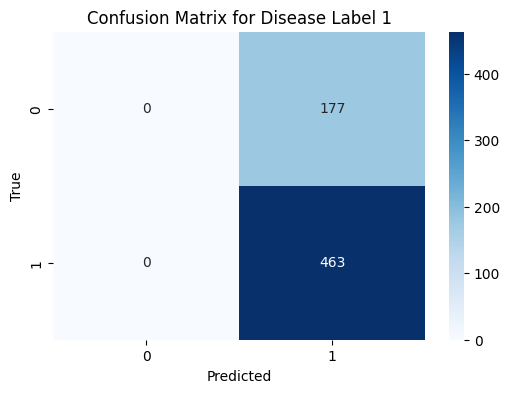

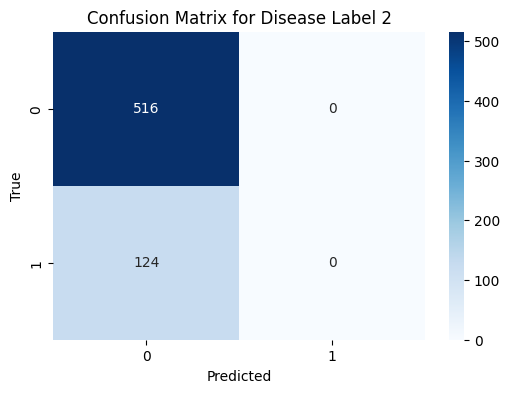

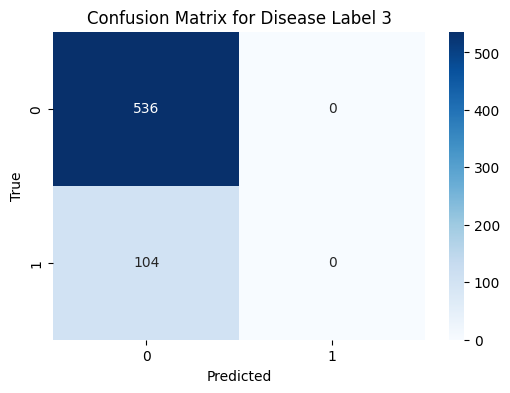

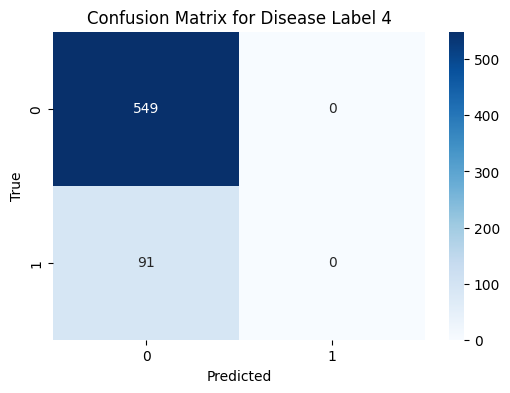

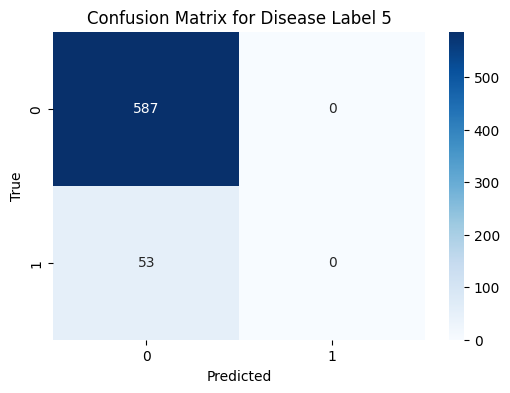

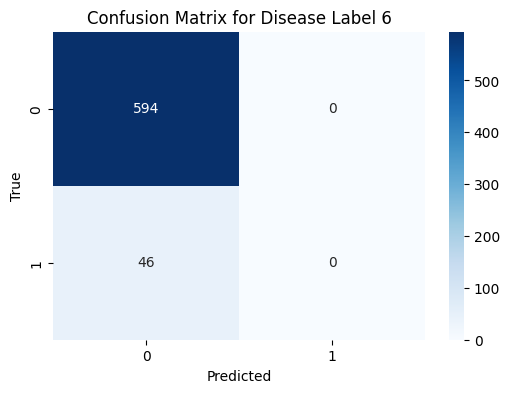

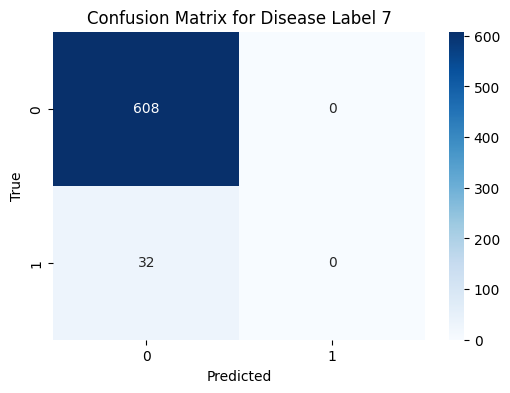

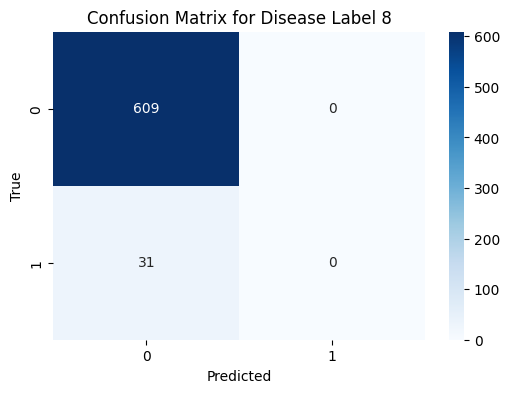

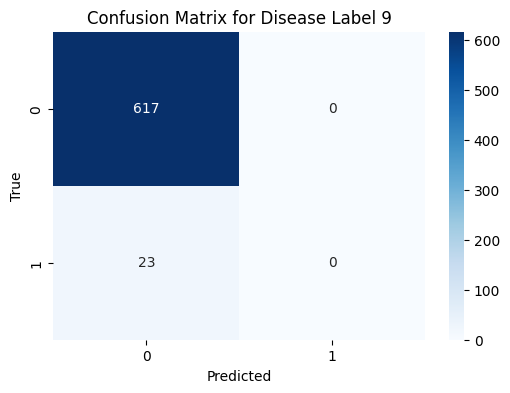

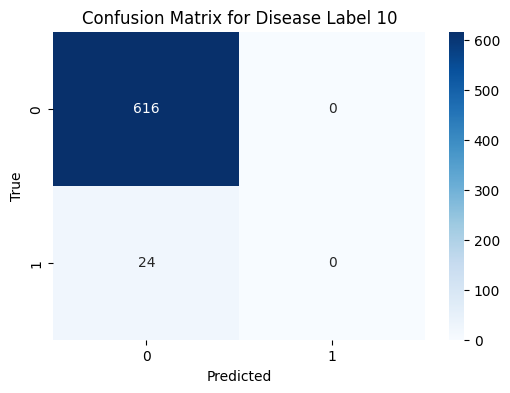

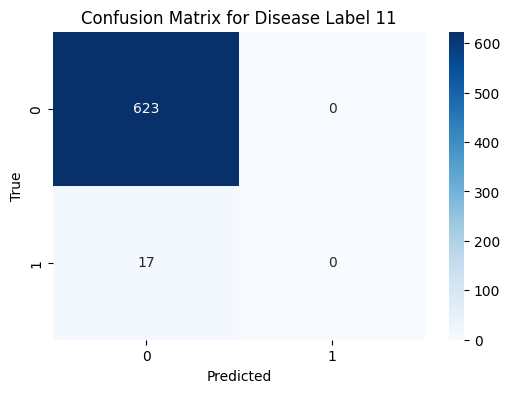

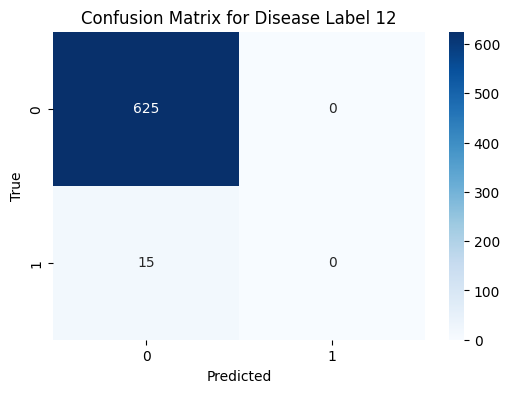

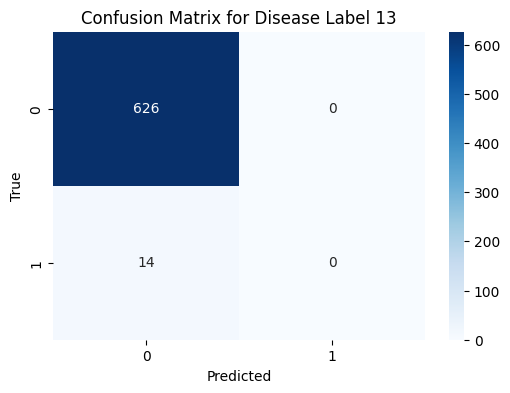

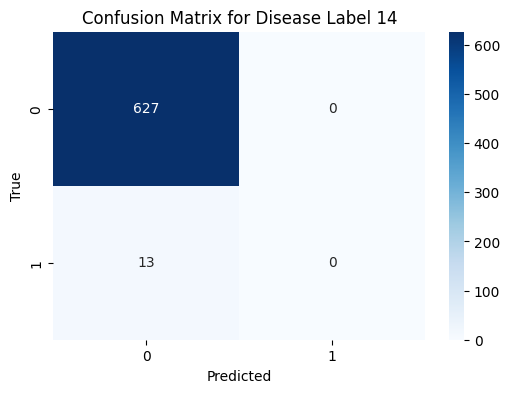

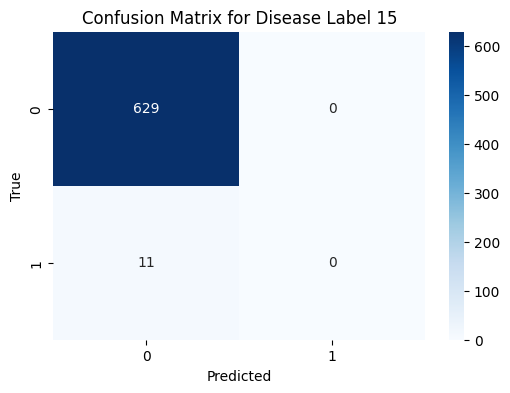

In [ ]:
y_true = []
y_pred = []

for i in range(len(test_generator)):
    X_batch, y_batch = test_generator[i]
    y_true.append(y_batch)
    y_pred.append(model.predict(X_batch))

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

y_pred_binary = (y_pred >= 0.5).astype(int)

for i in range(y_true.shape[1]):
    cm = confusion_matrix(y_true[:, i], y_pred_binary[:, i])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for Disease Label {i+1}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

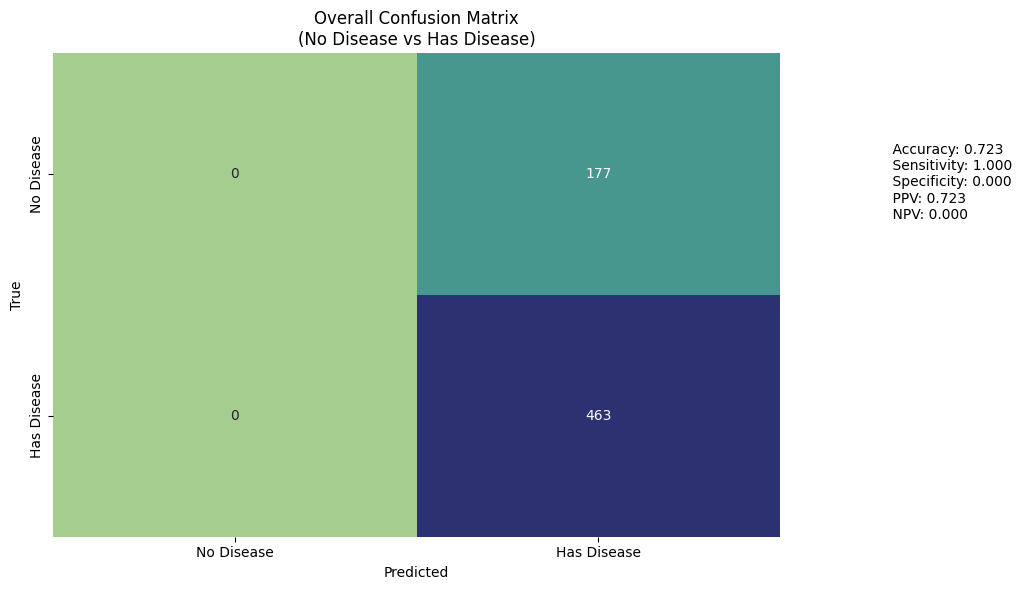

In [ ]:
def generate_overall_confusion_matrix(y_true, y_pred_binary):
    y_true_binary = (np.sum(y_true, axis=1) > 0).astype(int)
    y_pred_overall = (np.sum(y_pred_binary, axis=1) > 0).astype(int)
    
    cm = confusion_matrix(y_true_binary, y_pred_overall)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="crest", cbar=False, xticklabels=["No Disease", "Has Disease"], yticklabels=["No Disease", "Has Disease"])
    plt.title("Overall Confusion Matrix\n(No Disease vs Has Disease)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    metrics_text = f"""
    Accuracy: {accuracy:.3f}
    Sensitivity: {sensitivity:.3f}
    Specificity: {specificity:.3f}
    PPV: {ppv:.3f}
    NPV: {npv:.3f}
    """
    
    plt.figtext(1.1, 0.6, metrics_text, fontsize=10)
    plt.tight_layout()
    plt.show()
    
    return cm

cm = generate_overall_confusion_matrix(y_true, y_pred_binary)

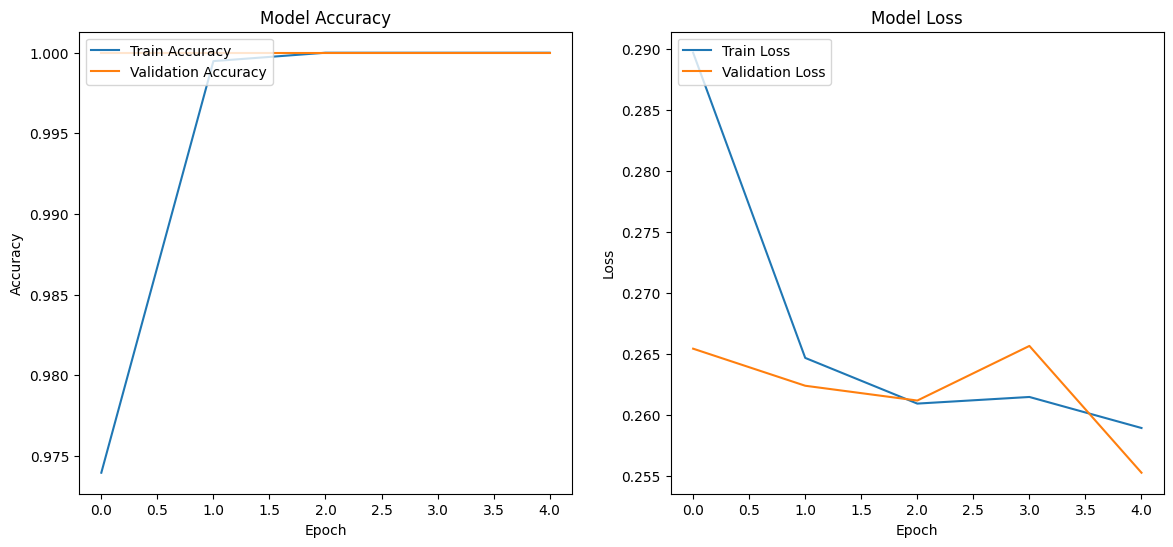

In [ ]:
def plot_training_curves(history):
    plt.figure(figsize=(14, 6))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    
    plt.show()

plot_training_curves(history)

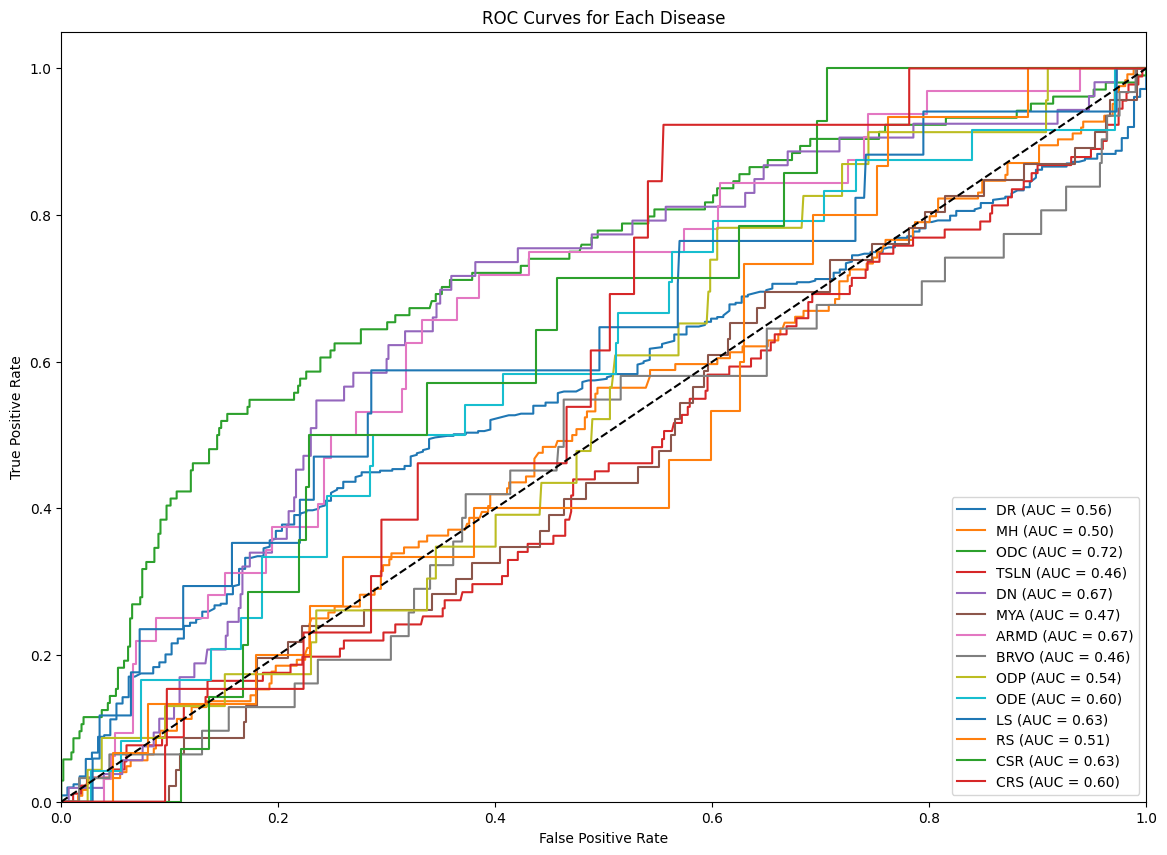

In [ ]:
# Plot ROC curve for each disease
plt.figure(figsize=(14, 10))
for i, disease in enumerate(selected_diseases):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{disease} (AUC = {roc_auc:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Disease')
plt.legend(loc="lower right")
plt.show()

In [13]:
model.save("retinal_disease_classifier.keras")

In [14]:
# Load the best model from the Keras file
model = load_model("retinal_disease_classifier.keras")

In [15]:
# Obtain predictions from the model on the test set
y_pred = model.predict(test_generator)

c:\Users\EliteBook\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 106s 5s/step


In [16]:
# Convert probabilities to binary predictions
y_pred_binary = (y_pred >= 0.5).astype(int)

In [17]:
def preprocess_image(img_path, target_size=(224, 224)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
    return np.expand_dims(img_array, axis=0)  # Add batch dimension

In [ ]:
img_path = "retinal-disease-classification\\Test_Set\\Test\\206.png"
preprocessed_img = preprocess_image(img_path)

y_pred_prob = model.predict(preprocessed_img)
y_pred_binary = (y_pred_prob >= 0.5).astype(int)  # Convert to binary (0 or 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [ ]:
image_id = 206
true_label = test_labels_filtered[test_labels_filtered["ID"] == image_id].iloc[0, 2:].values

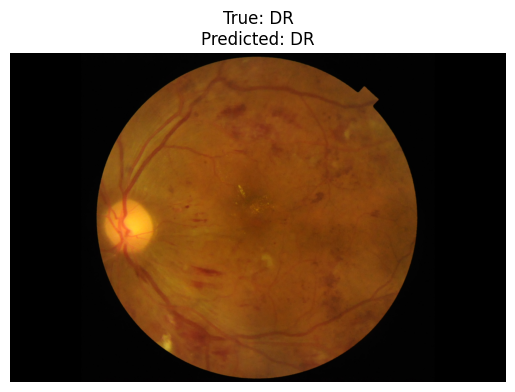

In [ ]:
y_pred_binary_diseases = y_pred_binary[0][:14]
true_label_diseases = true_label[:14]

diseases_present = np.array(selected_diseases)
true_diseases = diseases_present[true_label_diseases == 1]
predicted_diseases = diseases_present[y_pred_binary_diseases == 1]

plt.imshow(load_img(img_path))
plt.axis("off")
plt.title("True: " + ", ".join(true_diseases) + "\nPredicted: " + ", ".join(predicted_diseases))
plt.show()

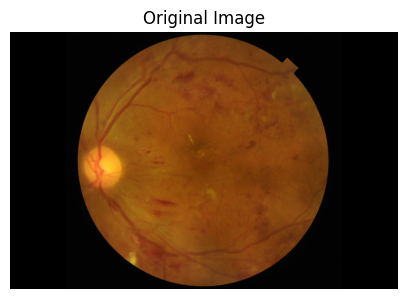

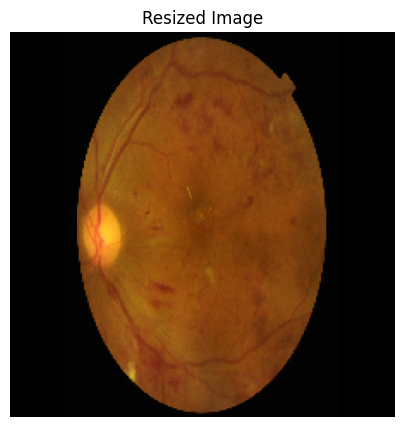

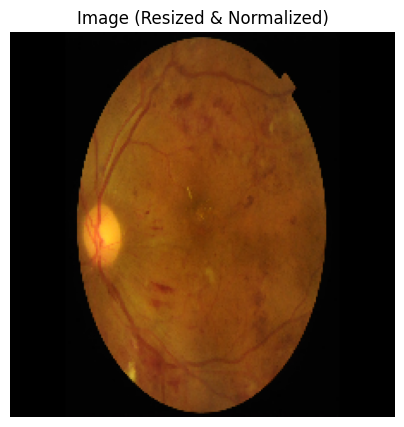

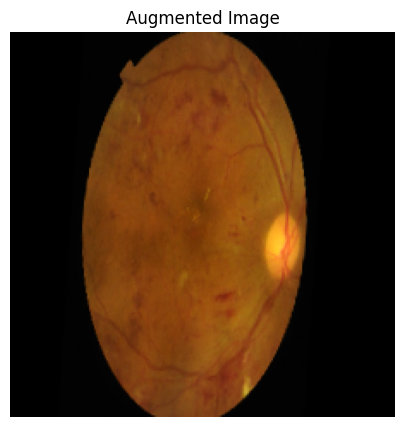

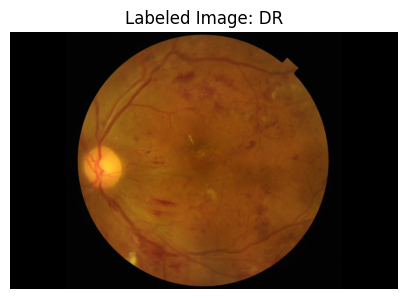

In [ ]:
def visualize_image_transforms(img_path, img_size=(224, 224), augment=False):
    img = load_img(img_path) 
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()
    
    
    img1 = load_img(img_path, target_size=img_size)
    plt.figure(figsize=(5,5))
    plt.imshow(img1)
    plt.title("Resized Image")
    plt.axis('off')
    plt.show()
    
    original_img = img_to_array(img1) / 255.0
    plt.figure(figsize=(5,5))
    plt.imshow(original_img)
    plt.title("Image (Resized & Normalized)")
    plt.axis('off')
    plt.show()

    if augment:
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.15,
            zoom_range=0.15,
            horizontal_flip=True
        )
        
        augmented_img = datagen.random_transform(original_img)
        
        plt.figure(figsize=(5,5))
        plt.imshow(augmented_img)
        plt.title("Augmented Image")
        plt.axis('off')
        plt.show()

    label = "DR"
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title(f"Labeled Image: {label}")
    plt.axis('off')
    plt.show()

img_path = 'retinal-disease-classification\\Test_Set\\Test\\206.png'
visualize_image_transforms(img_path, augment=True)